# Mount Google Drive

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [ ]:
!pip install barbar pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
import os
import random
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.tensorboard import SummaryWriter
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# Access the Directory for Training and Validation

In [ ]:
traindir = r'/content/drive/MyDrive/Skin/Data/training/'
valdir = r'/content/drive/MyDrive/Skin/Data/validation/'

# Data Preparation and Augmentation

Dataset consists of 7470 unique skin neoplasm photos with height=450 and width=600 pixels.

By examining the pictures it was noticed that in overwhelming majority off them the skin neoplasm is centerd and lies in the center 450x450 crop of the picture (with little exceptions).

Since we are using ResNet50, to get to 224x224 size, we will first resize to 224x280 (6.25% squeeze on width) and then center crop 224x224 piece.

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(
    traindir, transform=train_transforms)

val_dataset = datasets.ImageFolder(
    valdir, transform=val_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=True,
    pin_memory=False, drop_last=False)

In [ ]:
print(val_dataset.class_to_idx)
print(train_dataset.class_to_idx)

{'1.MEL': 0, '2.NV': 1, '3.BCC': 2, '4.AKIEC': 3, '5.BKL': 4, '6.DF': 5, '7.VASC': 6}
{'1.MEL': 0, '2.NV': 1, '3.BCC': 2, '4.AKIEC': 3, '5.BKL': 4, '6.DF': 5, '7.VASC': 6}


# Training

In [ ]:
device = 'cuda'

model = torchvision.models.resnet50(pretrained=True).to(device)

model.fc = nn.Linear(2048, 7).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.0001)

epochs = 299

writer = SummaryWriter(log_dir='/content/drive/MyDrive/skin_logs/', filename_suffix="skin50")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 58.0MB/s]


In [ ]:
# Shows info about model
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when monitored metric decrease.'''
        if self.verbose:
            self.trace_func(f'Monitored metric has improved ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'/content/drive/MyDrive/skinmodel50.pt')
        self.val_loss_min = val_loss

In [ ]:
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

early_stopping = EarlyStopping(patience=30, verbose=True)

for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_accuracy = Accuracy()
    val_accuracy = Accuracy()
    print(f'Epoch {epoch+1}')

    # Training loop
    for idx, (inputs, labels) in enumerate(Bar(train_loader)):
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    train_acc = train_accuracy.compute()
    train_accuracy_history.append(train_acc)
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_acc:.6f}")

    # Validation loop
    with torch.no_grad():
        for inputs, labels in val_loader:
            model.eval()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_accuracy.update((nn.functional.softmax(outputs, dim=1), labels))

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    val_acc = val_accuracy.compute()
    val_accuracy_history.append(val_acc)
    print(f"Val Loss: {val_loss:.6f} | Val Accuracy: {val_acc:.6f}")

    # Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# load the last checkpoint with the best model
model.load_state_dict(torch.load('/content/drive/MyDrive/skinmodel50.pt'))

Epoch 1
5973/5973: [===============================>] - ETA 41.1s
Train Loss: 0.751534 | Train Accuracy: 0.739829
Val Loss: 0.670559 | Val Accuracy: 0.762859
Monitored metric has improved (inf --> 0.670559).  Saving model ...
Epoch 2
5973/5973: [===============================>] - ETA 1.5s
Train Loss: 0.663015 | Train Accuracy: 0.765277
Val Loss: 0.628233 | Val Accuracy: 0.776887
Monitored metric has improved (0.670559 --> 0.628233).  Saving model ...
Epoch 3
5973/5973: [===============================>] - ETA 1.7s
Train Loss: 0.616559 | Train Accuracy: 0.778168
Val Loss: 0.618689 | Val Accuracy: 0.777555
Monitored metric has improved (0.628233 --> 0.618689).  Saving model ...
Epoch 4
5973/5973: [===============================>] - ETA 1.6s
Train Loss: 0.593886 | Train Accuracy: 0.785702
Val Loss: 0.671337 | Val Accuracy: 0.771543
EarlyStopping counter: 1 out of 30
Epoch 5
5973/5973: [===============================>] - ETA 1.4s
Train Loss: 0.564984 | Train Accuracy: 0.795580
Val Loss:

<All keys matched successfully>

              precision    recall  f1-score   support

         MEL       0.98      0.80      0.88       123
          NV       0.97      1.00      0.98      1081
         BCC       1.00      0.95      0.98        66
       AKIEC       0.94      1.00      0.97        46
         BKL       0.96      0.93      0.95       146
          DF       0.94      1.00      0.97        15
        VASC       1.00      1.00      1.00        20

    accuracy                           0.97      1497
   macro avg       0.97      0.95      0.96      1497
weighted avg       0.97      0.97      0.97      1497

AUC of class MEL = 0.9968343569898581
AUC of class NV = 0.998685778837259
AUC of class BCC = 0.9998941193909747
AUC of class AKIEC = 0.9998951248014862
AUC of class BKL = 0.9990519452865965
AUC of class DF = 0.9999550157444895
AUC of class VASC = 1.0


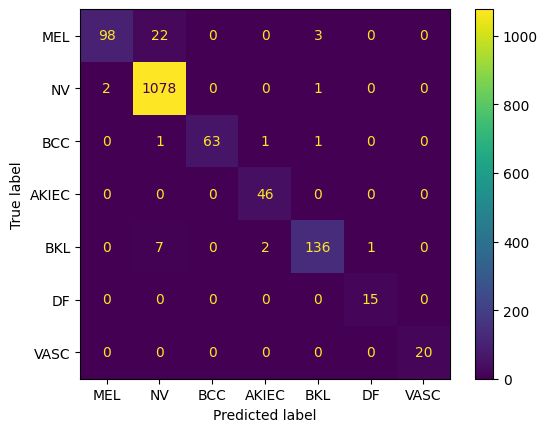

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
import numpy as np

num_classes = 7

predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')
predlistauc = torch.zeros(0, dtype=torch.float, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        model.eval()
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist = torch.cat([predlist, preds.view(-1).cpu()])
        lbllist = torch.cat([lbllist, classes.view(-1).cpu()])
        predlistauc = torch.cat([predlistauc, nn.functional.softmax(outputs, dim=1).cpu()])

predlist = predlist.numpy()
lbllist = lbllist.numpy()
predlistauc = predlistauc.numpy()

# Confusion matrix, classification report and AUC
conf_mat = confusion_matrix(lbllist, predlist)
target_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
ConfusionMatrixDisplay(conf_mat, display_labels=target_names).plot(values_format="d")
print(classification_report(lbllist, predlist, target_names=target_names))

for i, class_name in enumerate(target_names):
    class_indices = (lbllist == i)
    class_true = np.zeros((len(lbllist),), dtype=int)
    class_true[class_indices] = 1
    class_pred = predlistauc[:, i]
    auc_score = roc_auc_score(class_true, class_pred)
    print(f'AUC of class {class_name} = {auc_score}')


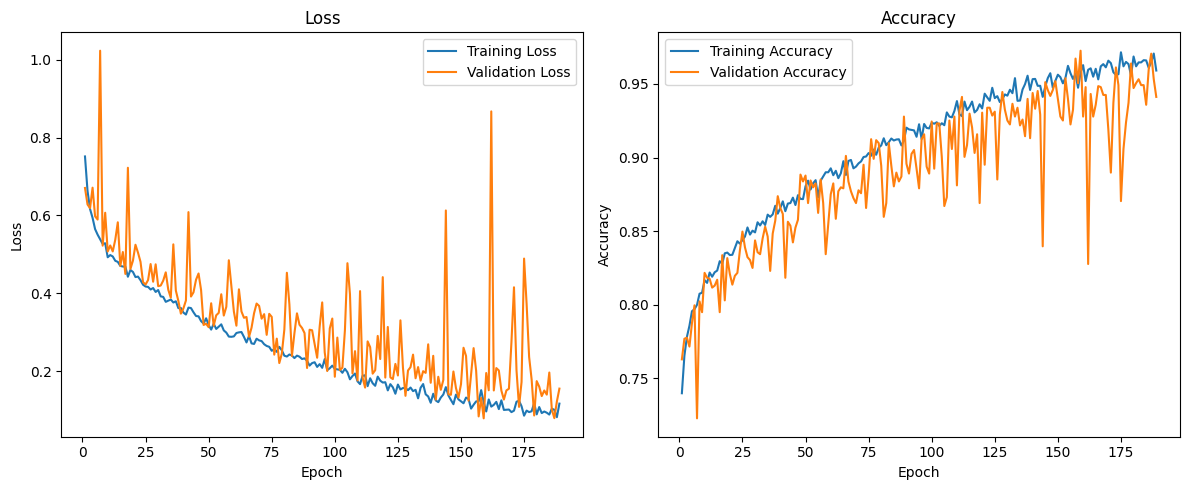

In [ ]:
import matplotlib.pyplot as plt
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_history) + 1), val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Result
Model stopped training after 189 epochs (around 8-9 hours on 1 Tesla P100 GPU) with Early stopping point at 159 epochs.

**Result metrics are:**

Train Accuracy: 0.957643

Val Accuracy: 0.972612

Training Loss: 0.120337

Validation Loss: 0.079050